# Using the _Herschel_-SPIRE Point Source Catalogue: demo \#1

This simple notebook demonstrates a simple use of the SPIRE Point Source Catalogue (SPSC). The user provides an Observation ID (OBSID) and the script will download the three SPIRE level-2 images for each band 250, 350 and 500 µm (mnemonic names `PSW`, `PMW` and `PLW` respectively) and will overlay the objects from the catalogue and optionally the sources from the initial source table.

**Required python packages:** `python 3.6` and above and the _standard_ `numpy`, `matplotlib` and `astropy`.

In [1]:
import os
import sys
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

sys.path.append(os.getcwd())
from getSpirePhotMaps import getSpirePhotMaps

Getting products from the _Herschel_ Science Archive through TAP involves downloading a .tar file. The next cell defines a temporary folder where the .tar file will be stored. It can be used as a quick way to have a cache of .tar files.

In [2]:
#
# set the Tmp where the archive .tar file will be stored
#
myTmp = os.path.join(os.path.expanduser('~'),"Tmp","HerschelData")
if (not os.path.isdir(myTmp)):
    print ("Temporary folder must exist! Please set it ip to point to an already existsing folder on your disk.")
    raise FileNotFountError

Next cell uses a definition `getSpirePhotMaps()` to download the maps for user-provided observation ID, `obsid`.

In [3]:
spire_bands = ["PSW","PMW","PLW"]
#
obsid = 1342188757
#
# download the maps, hmaps will be a dictionary of FITS HDUs with keys "PSW", "PMW" and "PLW"
#
hmaps = getSpirePhotMaps(obsid,tmpDir=myTmp)
target = hmaps['PSW'][0].header['OBJECT']

Found an already existing tar file for OBSID 1342188757. Will use it


Next cell access the URL where the SPIRE Point Source Catalog files can be found. For the time being, the new release is kept in a hidden folder `.release2`. This will change.

In [4]:
#
# now read the catalogue and sources, I will use the now hidden URL, change to the public one
# when released
#
legacy_url = 'http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-P/SPSC'
#cats_dir = '/Volumes/WORK/Works/herspire/SPIRE_PSC_v3/cats'
cats_dir = f'{legacy_url}/.release2/cats'
cat = {}
src = {}
for band in spire_bands:
    cat[band] = Table.read(f'{cats_dir}/{obsid}_{band}_catalog_sources.csv.gz',format='ascii.csv')
    src[band] = Table.read(f'{cats_dir}/{obsid}_{band}_sources.csv.gz',format='ascii.csv')
    print ("Found {} catalog entries for {}, band {}".format(len(cat[band]),obsid,band))
    print ("Found {} sources for {}, band {}".format(len(src[band]),obsid,band))

Found 202 catalog entries for 1342188757, band PSW
Found 257 sources for 1342188757, band PSW
Found 153 catalog entries for 1342188757, band PMW
Found 215 sources for 1342188757, band PMW
Found 50 catalog entries for 1342188757, band PLW
Found 68 sources for 1342188757, band PLW


And finally we plot the catalog objects and the sources in the next cell.

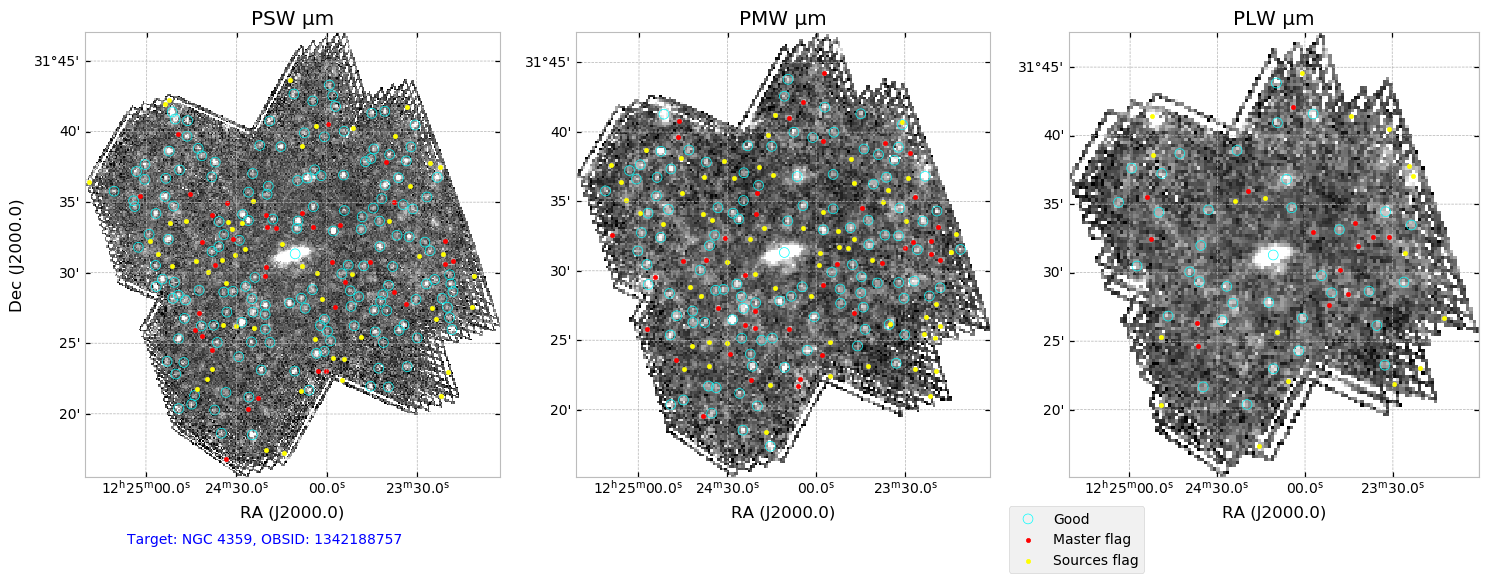

In [5]:
#
# plot the maps and the sources
#
#
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # 
for k,band in enumerate(spire_bands):
    wcs = WCS(hmaps[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title(f'{band} µm')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    if (k == 0):
        lat.set_axislabel('Dec (J2000.0)')
    else:
        lat.set_axislabel('')
    lat.set_major_formatter('dd:mm')    
    ximage = hmaps[band]['image']
    norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    ax.imshow(ximage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    #
    # now plot the catalog and sources, filtering those with master flag in both catalog
    # and source tables
    #
    rax = cat[band]['ra']
    decx = cat[band]['dec']
    igood = np.where(cat[band]['master'] == 't')[0]
    ibad = np.where(cat[band]['master'] == 'f')[0]
    #
    # the sources
    #
    raz = src[band]['ra']
    decz = src[band]['dec']
    iz = np.where(src[band]['master'] == 'f')[0]
    #
    ax.scatter(rax[igood], decx[igood], transform=ax.get_transform('world'), 
               s=50,edgecolor='cyan', facecolor='none', label='Good')
    ax.scatter(rax[ibad], decx[ibad], transform=ax.get_transform('world'), 
               marker='.', c='red', label='Master flag')
    ax.scatter(raz[iz], decz[iz], transform=ax.get_transform('world'), 
               marker='.', c='yellow', label='Sources flag')
    if (k == 0):
        ax.text(0.1,-0.15,f'Target: {target}, OBSID: {obsid}',transform=ax.transAxes,color='b')
plt.tight_layout(pad=2)
lgnd = plt.legend(bbox_to_anchor=(0.2, -0.05))
lgnd.legendHandles[0]._sizes = [50];

## Explaining the postcards

To explain the postcards we have to explain the catalogue and the source tables. Much more details are given in the [Explanatory Supplement](http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-P/SPSC/SPIREPointSourceCatalogExplanatorySupplementFull20170203.pdf), so please consult this document. 

The catalogue objects are consolidated from the individual sources at the source detection stage. The source detection stage is performed on level-2 or level-2.5 SPIRE Photometer maps. For regions of the sky that SPIRE observed only once, the catalogue object is the source, if the source characteristics are such that it passes the DAOphot rejection criteria. The catalogue parameter `nmap` is the actual number of maps where the object (ra,dec) is within the good coverage area. In cases with multiple maps (i.e. `nmap` > 1), the individual sources are consolidated/grouped into one catalogue object. How many sources were grouped in a catalogue object is encoded with the parameter `ndet`.

The postcards show the good catalogue objects as cyan circles. The red points are the flagged catalogue entries, i.e. discarded objects with `master = False`. The flagging can be due to high structure noise, poor timeline fitter fit, etc. 

The yellow symbols are the sources form the individual per-OBSID extraction phase that were flagged: either rejected by DAOPhot compactness or sharpness parameters or by other criteria. 